In [2]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Load the dataset
data = pd.read_csv('amazon.csv')

# Drop rows with missing values
data.dropna(inplace=True)

# Text preprocessing function
def preprocess_text(text):
    # Remove emojis
    text = emoji.demojize(text)
    text = re.sub(r':[^:\s]+:', '', text)
    text = re.sub(r'::', '', text)

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if not word in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]  # Lemmatize
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
data['preprocessed'] = data['review_content'].apply(preprocess_text)

# POS tagging and extracting adjectives and adverbs
def extract_adj_adv(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return ' '.join([word for word, tag in tagged if tag in ['JJ', 'RB']])

data['adj_adv_only'] = data['preprocessed'].apply(extract_adj_adv)

# Convert the 'adj_adv_only' Series to a DataFrame
adj_adv_df = data['adj_adv_only'].to_frame()

# Save the DataFrame to a CSV file
adj_adv_df.to_csv('adj_adv_only.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
sia = SentimentIntensityAnalyzer()

def compute_sentiment_score(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']  # Return the compound score

data['sentiment_score'] = data['adj_adv_only'].apply(compute_sentiment_score)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['adj_adv_only'])

# Combine TF-IDF scores with sentiment scores
tfidf_scores = tfidf_matrix.toarray()
sentiment_scores = data['sentiment_score'].values

# Calculate the product of TF-IDF scores and sentiment scores for each word in each review
combined_scores = np.multiply(tfidf_scores, sentiment_scores[:, None])

# Store terms and their combined scores in a DataFrame
feature_names = tfidf_vectorizer.get_feature_names_out()
combined_scores_mean = np.mean(combined_scores, axis=0)
combined_df = pd.DataFrame({'Term': feature_names, 'Combined Score': combined_scores_mean})

# Sort the DataFrame by combined scores
combined_df_sorted = combined_df.sort_values(by='Combined Score', ascending=False)

# Print the top 10 terms
print(combined_df_sorted.head(10))

        Term  Combined Score
2280    good        0.112621
185     also        0.036850
1566    easy        0.035719
6947    well        0.030491
2377   great        0.026688
5008  really        0.026657
3863    nice        0.025659
1900    fast        0.025627
1738    even        0.022596
1980    fine        0.021361


In [12]:
# Extract comments for each top keyword excluding meaningless keywords
top_keywords = combined_df_sorted['Term'].head(10).tolist()
meaningless_keywords = ['also', 'really', 'even']
top_keywords = [keyword for keyword in top_keywords if keyword not in meaningless_keywords]

keyword_comments = {}

for keyword in top_keywords:
    # Filter the data to include only rows containing the keyword in the 'adj_adv_only' column
    filtered_data = data[data['adj_adv_only'].str.contains(keyword)]

    # Extract comments for the filtered data
    comments = filtered_data['review_content'].tolist()

    # Store the comments for the keyword
    keyword_comments[keyword] = comments

# Convert the dictionary to a list of DataFrames
dfs = []
for keyword, comments in keyword_comments.items():
    # Get the ratings corresponding to the comments
    ratings = []
    for comment in comments:
        # Find the rating corresponding to each comment
        rating = data[data['review_content'] == comment]['rating'].values[0]
        ratings.append(rating)
    # Create a DataFrame with both comments and ratings
    df = pd.DataFrame({'Term': keyword, 'Comment': comments, 'Rating': ratings})
    dfs.append(df)

# Concatenate all DataFrames into one
comments_df = pd.concat(dfs, ignore_index=True)

# Save the DataFrame to a CSV file
comments_df.to_csv('keyword_comments_with_rating.csv', index=False)


In [13]:
# Convert the 'Rating' column to numeric
comments_df['Rating'] = pd.to_numeric(comments_df['Rating'], errors='coerce')

# Group the DataFrame by 'Term' and calculate the mean of 'Rating' for each group
average_ratings = comments_df.groupby('Term')['Rating'].mean().reset_index()

# Print the DataFrame with average ratings
print(average_ratings)


    Term    Rating
0   easy  4.140956
1   fast  4.151042
2   fine  4.117685
3   good  4.105348
4  great  4.134190
5   nice  4.108848
6   well  4.131361


In [14]:
# Merge the DataFrames on the 'Term' column
merged_df = pd.merge(average_ratings, combined_df_sorted, on='Term', how='inner')
# Calculate the correlation coefficient
correlation = merged_df['Rating'].corr(merged_df['Combined Score'])

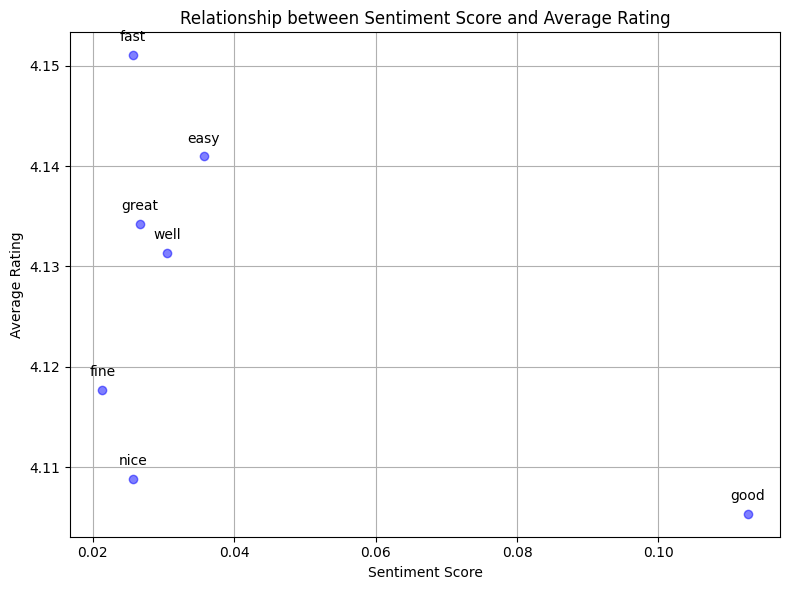

In [15]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(merged_df['Combined Score'], merged_df['Rating'], color='blue', alpha=0.5)
plt.title('Relationship between Sentiment Score and Average Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Average Rating')
plt.grid(True)

# Add annotations for each point
for i, txt in enumerate(merged_df['Term']):
    plt.annotate(txt, (merged_df['Combined Score'][i], merged_df['Rating'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
